# Alzheimer & MCI DeepLearning(CNN) Classifier
- ADNI MRI 이미지로 알츠하이머와 경도인지장애를 분류하는 딥러닝 프로젝트
- 데이터 출처
  - 메타데이터 : https://ida.loni.usc.edu/
  - MRI이미지 : https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial
- 저작권에 의해 데이터는 깃허브에 업로드 하지 않았음

## Part2-1. Modeling (Vanilla CNN)
- 본 작업은 Google Colaboratory(Colab)에서 진행되었음.
  - Python version : 3.8
  - Tensorflow version : 2.9

### 1. Library & Data Import

- Library Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

- Google Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Directory 지정 & 폴더 확인

In [3]:
base_dir = "/content/drive/MyDrive/AI/Alzheimer/Axial"
os.listdir(base_dir)

['CN', 'AD', 'MCI']

- Image Data 수 확인

In [4]:
class_list = ['CN', 'MCI', 'AD']
number_of_images = {}
for class_name in class_list:
  number_of_images[class_name]=len(os.listdir(base_dir+"/"+class_name))
image_count_df = pd.DataFrame(number_of_images.values(),
                              index=number_of_images.keys(),
                              columns=["Number of Images"])
display(image_count_df)
print("\nSum of images : {}".format(image_count_df.sum()[0]))

,Number of Images
CN,1440
MCI,2590
AD,1124



Sum of images : 5154


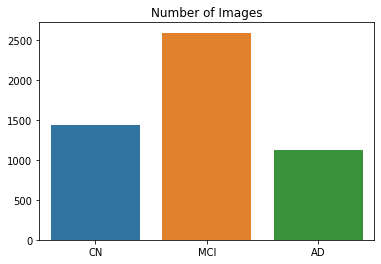

In [5]:
sns.barplot(data=image_count_df.T)
plt.title('Number of Images')
plt.show()

- Global 변수 지정
  - 이미지 크기(256), 배치사이즈(32), 채널(3), 에포크(10), 시드(42)

In [6]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
SEED = 42

- Data 불러오기

In [7]:
dataset = image_dataset_from_directory(
    base_dir,
    shuffle=True,
    class_names=class_list,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    seed=SEED
)

Found 5154 files belonging to 3 classes.


- 데이터 확인
  - Batch 하나 뽑아서 형태 및 Label 확인하였음

In [8]:
# Data 확인
for img_batch1, label_batch1 in dataset.take(1):
  print(img_batch1.shape)
  print(label_batch1.numpy())
  print(label_batch1.shape)

(32, 256, 256, 3)
[2 2 1 1 1 1 1 2 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 2 1 0 0 0]
(32,)


- 이미지 데이터 픽셀값 범위 확인
  - 정규화는 모델에 정규화 layer를 포함시킬 예정이라 정규화를 먼저 진행하지 않았음 

In [9]:
np.min(img_batch1), np.max(img_batch1)

(0.0, 255.0)

In [10]:
print(np.unique(label_batch1))
print(dataset.class_names)

[0 1 2]
['CN', 'MCI', 'AD']


- 데이터 확인 (matplotlib)
  - 이미지 데이터를 제대로 불러왔는지를 확인하기 위함
  - Part3에서 다시 확인 할 예정

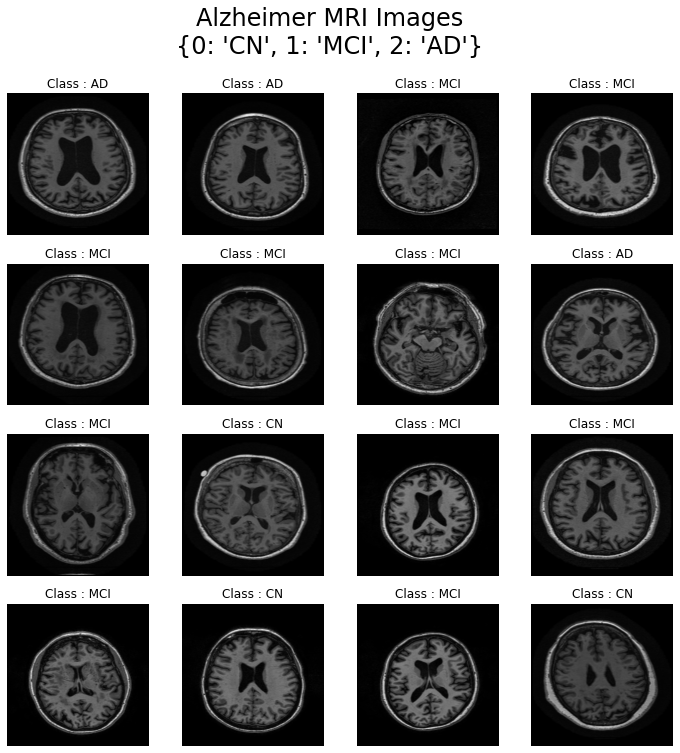

In [11]:
class_dict = dict(zip(np.unique(label_batch1),dataset.class_names))

plt.figure(figsize=(12,12))
plt.suptitle(f"Alzheimer MRI Images\n{class_dict}", fontsize=24)
for i in range(16):
  ax = plt.subplot(4,4,i+1)
  img_arr = img_batch1[i].numpy()
  plt.imshow(img_arr.astype("uint8"))
  plt.axis("off")
  plt.title("Class : {}".format(class_list[label_batch1[i].numpy()]))

### 2. Data Split & Prefetch

- Data Split
  - Train : Validation : Test = 0.8 : 0.1 : 0.1
  - Batch 단위로 묶인 데이터라 Batch단위로 Split

In [12]:
def dataset_split(ds, tr=0.8, val=0.1, test=0.1, shuffle=True, buf_size=10000, SEED=42):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(buf_size,seed=SEED)
  train_size = int(ds_size*tr)
  val_size = int(ds_size*test)
  
  train = ds.take(train_size)
  test0 = ds.skip(train_size)
  val = test0.take(val_size)
  test = test0.skip(val_size)

  return train,val,test

In [13]:
train_ds, val_ds, test_ds = dataset_split(dataset)
print("Split전 Batched data 개수")
print(f"Dataset : {len(dataset)}")
print("\nSplit후 Batched data 개수")
print(f"Train : {len(train_ds)}")
print(f"Validation : {len(val_ds)}")
print(f"Test : {len(test_ds)}")

Split전 Batched data 개수
Dataset : 162

Split후 Batched data 개수
Train : 129
Validation : 16
Test : 17


- Data Prefetch
  - 속도를 향상시키기 위한 목적

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### 3. Modeling (Vanilla CNN)
- 가장 기본적인 CNN 구조로 모델링 진행
- 정규화
  - Resizing : (256,256)으로 크기 맞춤
  - Rescaling : 0~255의 데이터를 0~1로 정규화
- 데이터 증강 (Augmentation) - Train dataset에만 적용되는 layer
  - RandomFlip : 수직, 수평으로 데이터를 뒤집어 훈련데이터를 증강
  - RandomRotation : 0.1정도를 Random하게 기울여 훈련데이터를 증강
- CNN 모델
  - 데이터 특징 추출 layer (Feature Extractor)
    - Conv2D 와 MaxPooling으로 이루어진 2개의 블럭(Block)
      - Conv2D
        - 필터(filter) : 3x3
        - 풀링(pooling) : same
        - 활성화함수 : relu
      - MaxPooling : 2x2
  - 데이터 분류 layer (Classifier)
    - Flatten으로 펼침
    - 1개의 은닉층(노드수=64, 활성화함수=relu)
    - 다중 분류 출력층(노드수=3, 활성화함수=softmax)
- 모델 컴파일(compile)
  - Optimizer : Adam
  - 손실함수 (Loss function) : Sparse Categorical Crossentropy
  - 평가지표 (Metrics) : Accuracy 

In [15]:
# 정규화 및 증강 layer 정의
resize_rescale = Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1.0/255)
])
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", seed=SEED),
    RandomRotation(0.1, seed=SEED)
])

- Model building

In [16]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)

model1 = Sequential([
    resize_rescale,
    data_augmentation,
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model1.build(input_shape)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                  

- Model Compile

In [17]:
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['acc'])

### 4. Training Model (fit)

In [18]:
history1 = model1.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/10
129/129 [==============================] - 46s 188ms/step - loss: 1.1047 - acc: 0.4903 - val_loss: 0.9882 - val_acc: 0.5508
Epoch 2/10
129/129 [==============================] - 11s 88ms/step - loss: 0.9373 - acc: 0.5560 - val_loss: 0.8607 - val_acc: 0.5762
Epoch 3/10
129/129 [==============================] - 11s 88ms/step - loss: 0.8141 - acc: 0.6320 - val_loss: 0.7066 - val_acc: 0.6895
Epoch 4/10
129/129 [==============================] - 11s 87ms/step - loss: 0.7103 - acc: 0.6984 - val_loss: 0.6093 - val_acc: 0.7773
Epoch 5/10
129/129 [==============================] - 11s 87ms/step - loss: 0.6309 - acc: 0.7343 - val_loss: 0.5016 - val_acc: 0.7871
Epoch 6/10
129/129 [==============================] - 11s 87ms/step - loss: 0.5339 - acc: 0.7849 - val_loss: 0.5746 - val_acc: 0.7793
Epoch 7/10
129/129 [==============================] - 11s 88ms/step - loss: 0.4762 - acc: 0.8098 - val_loss: 0.3743 - val_acc: 0.8574
Epoch 8/10
129/129 [==============================] - 11s 88m

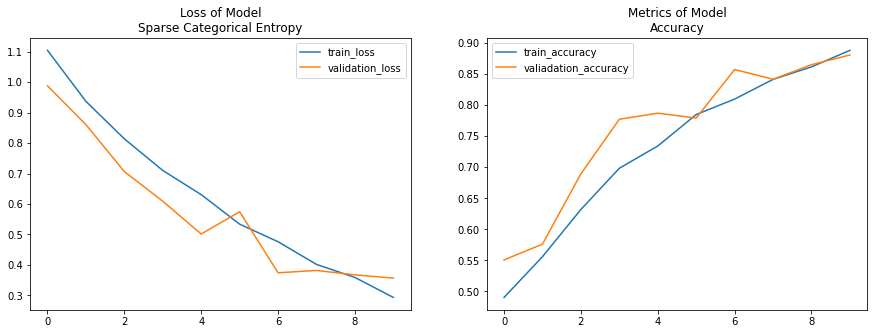

In [19]:
loss1 = history1.history['loss']
acc1 = history1.history['acc']
val_loss1 = history1.history['val_loss']
val_acc1 = history1.history['val_acc']

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="validation_loss")
plt.title("Loss of Model\nSparse Categorical Entropy")
plt.legend()

plt.subplot(122)
plt.plot(acc1, label="train_accuracy")
plt.plot(val_acc1, label="valiadation_accuracy")
plt.title("Metrics of Model\nAccuracy")
plt.legend()

plt.show()

### 5. Evaluation (일반화 가능성 확인)

- 테스트 데이터셋 검증(Evaluation)

In [21]:
model1.evaluate(test_ds, verbose=1)

17/17 [==============================] - 13s 33ms/step - loss: 0.3569 - acc: 0.8713


[0.35692793130874634, 0.8713235259056091]

- 테스트 데이터셋 예측 클래스 확인
  - 시각화는 Part3에서 진행하였음

In [22]:
predictions = model1.predict(test_ds)
predict_class = np.argmax(predictions, axis=1)
print(predict_class[:5])

17/17 [==============================] - 1s 29ms/step
[1 0 0 1 2]


### 6. Model Export (모델 저장, 부호화)

- Model Encoding (Save Model to hdf5 file)

In [23]:
model1.save(filepath="/content/drive/MyDrive/AI/Alzheimer/model1.hdf5")

- 모델 불러와서 저장이 제대로 됐는지 확인

In [24]:
model = tf.keras.models.load_model(filepath="/content/drive/MyDrive/AI/Alzheimer/model1.hdf5")
model.evaluate(test_ds, verbose=1)

17/17 [==============================] - 1s 32ms/step - loss: 0.3569 - acc: 0.8713


[0.35692790150642395, 0.8713235259056091]

## Part2-2 ~

- RAM 한도 초과로 인해 이후 과정들은 새로운 Colab file로 진행하였음.

- Part2-2. 모델 개선 1 : 전이학습 (Tranfer Learning)
  - ResNet50V2
- Part2-3. 모델 개선 2 : 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
  - Keras-Tuner
  - Hyperband